TODO: learned vocab should only be over the vocab in the cipher. in other words
X should be `n words x n letters x n cipher vocab` and $\pi$ should be 
`n cipher vocab x n vocab

In [1]:
# https://www.math.uci.edu/~jxin/AutoShuffleNet_KDD2020F.pdf

In [2]:
import string
import numpy as np

CRYPTOGRAM = '''
I'm parting the sea between brightness and me
Before I drown myself and everyone and everything

I got my hands behind my back
With two fingers overlapped
Because I can never keep my word
And I share with the undeserved
For some cheap acceptance in return
The water will shape the sides
And I'll walk with my head held high
And when it all comes crashing in
It will be worth it, if I'm still breathing

If actions speak louder than words
I'm the most deafening noise you've heard
I'll be that ringing in your ears
That will stick around for years
'''.translate(str.maketrans({k: '' for k in string.punctuation+'“”—’'})).upper()

mapping = {
    a: b
    for a, b in zip(string.ascii_uppercase, sorted(string.ascii_uppercase, key=lambda _: np.random.rand()))
}
CRYPTOGRAM = CRYPTOGRAM.translate(str.maketrans(mapping)).upper().split()
CRYPTOGRAM = [
    w1 + ' ' + w2
    for w1, w2 in zip(CRYPTOGRAM[:-1], CRYPTOGRAM[1:])
]

In [3]:
CRYPTOGRAM

['KT VOFIKQD',
 'VOFIKQD IRJ',
 'IRJ EJO',
 'EJO PJIMJJQ',
 'PJIMJJQ PFKDRIQJEE',
 'PFKDRIQJEE OQC',
 'OQC TJ',
 'TJ PJGBFJ',
 'PJGBFJ K',
 'K CFBMQ',
 'CFBMQ TYEJZG',
 'TYEJZG OQC',
 'OQC JUJFYBQJ',
 'JUJFYBQJ OQC',
 'OQC JUJFYIRKQD',
 'JUJFYIRKQD K',
 'K DBI',
 'DBI TY',
 'TY ROQCE',
 'ROQCE PJRKQC',
 'PJRKQC TY',
 'TY PONW',
 'PONW MKIR',
 'MKIR IMB',
 'IMB GKQDJFE',
 'GKQDJFE BUJFZOVVJC',
 'BUJFZOVVJC PJNOHEJ',
 'PJNOHEJ K',
 'K NOQ',
 'NOQ QJUJF',
 'QJUJF WJJV',
 'WJJV TY',
 'TY MBFC',
 'MBFC OQC',
 'OQC K',
 'K EROFJ',
 'EROFJ MKIR',
 'MKIR IRJ',
 'IRJ HQCJEJFUJC',
 'HQCJEJFUJC GBF',
 'GBF EBTJ',
 'EBTJ NRJOV',
 'NRJOV ONNJVIOQNJ',
 'ONNJVIOQNJ KQ',
 'KQ FJIHFQ',
 'FJIHFQ IRJ',
 'IRJ MOIJF',
 'MOIJF MKZZ',
 'MKZZ EROVJ',
 'EROVJ IRJ',
 'IRJ EKCJE',
 'EKCJE OQC',
 'OQC KZZ',
 'KZZ MOZW',
 'MOZW MKIR',
 'MKIR TY',
 'TY RJOC',
 'RJOC RJZC',
 'RJZC RKDR',
 'RKDR OQC',
 'OQC MRJQ',
 'MRJQ KI',
 'KI OZZ',
 'OZZ NBTJE',
 'NBTJE NFOERKQD',
 'NFOERKQD KQ',
 'KQ KI',
 'KI MKZZ',
 'MKZZ PJ'

In [4]:
CRYPTOGRAM = '''
ED KFT JPRN UERVB VPYB DP YC
FDDBRDEPR DKFD IBPIJB PA
FVVPYIJEUKYBRD OFOBJC UFD QFVX FRT
JBD DKERNU KFIIBR DP DKBY DKBC LBRD
PHD FRT KFIIBRBT DP DKERNU
'''.upper().split()

CRYPTOGRAM = [
    w1 + ' ' + w2
    for w1, w2 in zip(CRYPTOGRAM[:-1], CRYPTOGRAM[1:])
]

In [5]:
import string

CRYPTOGRAM = '''
DCXG L MYXG QCXZ, ZMNQ MO QCX VMMFN
CJUX QCX NZXRR MO JG XJWRLXW QLZX
RXJFLGE MKQ VXQDXXG QCX YJEXN - J
NYXALJR MPMW MO QCX FGMDRXPEX JGP
XZMQLMGN QCJQ OMW JEXN CJUX VXXG
AJRZRT WXNQLGE VXQDXXG QCX AMUXWN.
VWXJQCLGE LQ LG, L ERJGAX QCWMKEC J
OXD YJEXN VXOMWX WXQKWGLGE XJAC VMMF
QM LQN NCXRO.
'''.translate(str.maketrans({s: '' for s in string.punctuation})).upper().split()

CRYPTOGRAM = [
    w1 + ' ' + w2
    for w1, w2 in zip(CRYPTOGRAM[:-1], CRYPTOGRAM[1:])
]

In [6]:
CRYPTOGRAM

['DCXG L',
 'L MYXG',
 'MYXG QCXZ',
 'QCXZ ZMNQ',
 'ZMNQ MO',
 'MO QCX',
 'QCX VMMFN',
 'VMMFN CJUX',
 'CJUX QCX',
 'QCX NZXRR',
 'NZXRR MO',
 'MO JG',
 'JG XJWRLXW',
 'XJWRLXW QLZX',
 'QLZX RXJFLGE',
 'RXJFLGE MKQ',
 'MKQ VXQDXXG',
 'VXQDXXG QCX',
 'QCX YJEXN',
 'YJEXN J',
 'J NYXALJR',
 'NYXALJR MPMW',
 'MPMW MO',
 'MO QCX',
 'QCX FGMDRXPEX',
 'FGMDRXPEX JGP',
 'JGP XZMQLMGN',
 'XZMQLMGN QCJQ',
 'QCJQ OMW',
 'OMW JEXN',
 'JEXN CJUX',
 'CJUX VXXG',
 'VXXG AJRZRT',
 'AJRZRT WXNQLGE',
 'WXNQLGE VXQDXXG',
 'VXQDXXG QCX',
 'QCX AMUXWN',
 'AMUXWN VWXJQCLGE',
 'VWXJQCLGE LQ',
 'LQ LG',
 'LG L',
 'L ERJGAX',
 'ERJGAX QCWMKEC',
 'QCWMKEC J',
 'J OXD',
 'OXD YJEXN',
 'YJEXN VXOMWX',
 'VXOMWX WXQKWGLGE',
 'WXQKWGLGE XJAC',
 'XJAC VMMF',
 'VMMF QM',
 'QM LQN',
 'LQN NCXRO']

In [7]:
from collections import defaultdict

def word_group(w):
    return tuple([
        len(set(w[:i]))
        for
        i in range(len(w))
    ])

search_space = set()
for word in CRYPTOGRAM:
    search_space.add(word_group(word))
list(search_space)[:5]

[(0, 1, 2, 3, 4, 5),
 (0, 1, 2, 3, 4, 5, 6, 6),
 (0, 1, 2, 3, 4, 5, 5, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7, 7, 8),
 (0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10)]

In [8]:
import string
from cryptogram import vectorize_text

CRYPTOGRAM_ALPHABET = ''.join(sorted(set(''.join(CRYPTOGRAM) + ' ')))
TARGET_ALPHABET = string.ascii_uppercase + ' '
len(CRYPTOGRAM_ALPHABET), len(TARGET_ALPHABET)

(23, 27)

# frequencies

In [9]:
import glob
import pandas as pd

def load_ngrams(f):
    df = pd.read_csv(f)
    df['word_group'] = df.ngram.str.strip().apply(word_group)
    return df[df.word_group.apply(search_space.__contains__)]

frequencies = pd.concat((load_ngrams(f) for f in glob.glob('ngrams/*-clean.csv.gz')))
frequencies.shape

(1495144, 3)

In [10]:
frequencies.head()

,ngram,occurrences,word_group
10,AB Astra,2,"(0, 1, 2, 3, 3, 4, 5, 6)"
11,AB Canada,59,"(0, 1, 2, 3, 4, 5, 6, 6, 7)"
15,AB drawn,3,"(0, 1, 2, 3, 4, 5, 6, 7)"
16,ABA may,20,"(0, 1, 2, 2, 3, 4, 5)"
18,ABC a,21,"(0, 1, 2, 3, 4)"


In [11]:
frequencies = frequencies[frequencies.occurrences.gt(100)]
frequencies.shape

(157103, 3)

In [12]:
frequencies['word'] = frequencies.ngram.str.strip().str.upper()
frequencies['log_likelihood'] = (
    np.log10(frequencies.occurrences)
    # TODO: should also group by length of word and/or space index
    - np.log10(frequencies.word_group.map(frequencies.groupby('word_group').occurrences.sum()))
)

<Axes: >

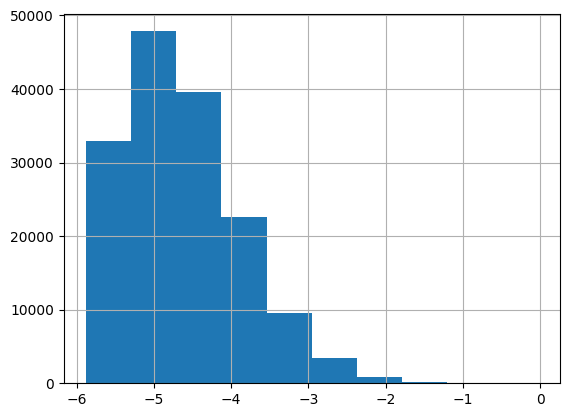

In [13]:
frequencies.log_likelihood.hist()

In [14]:
dictionary = frequencies
dictionary.shape

(157103, 5)

### test on cipher

In [15]:
X = vectorize_text(CRYPTOGRAM, TARGET_ALPHABET)
V = vectorize_text(dictionary.word.tolist(), TARGET_ALPHABET)
X.shape, V.shape

((53, 16, 27), (157103, 16, 27))

# Get Masks

In [16]:
def get_shared_word_separater_mask(text1, text2):
    separater_pos1 = np.array([w.index(' ') for w in text1])
    separater_pos2 = np.array([w.index(' ') for w in text2])
    return separater_pos1[:, None] == separater_pos2[None, :]

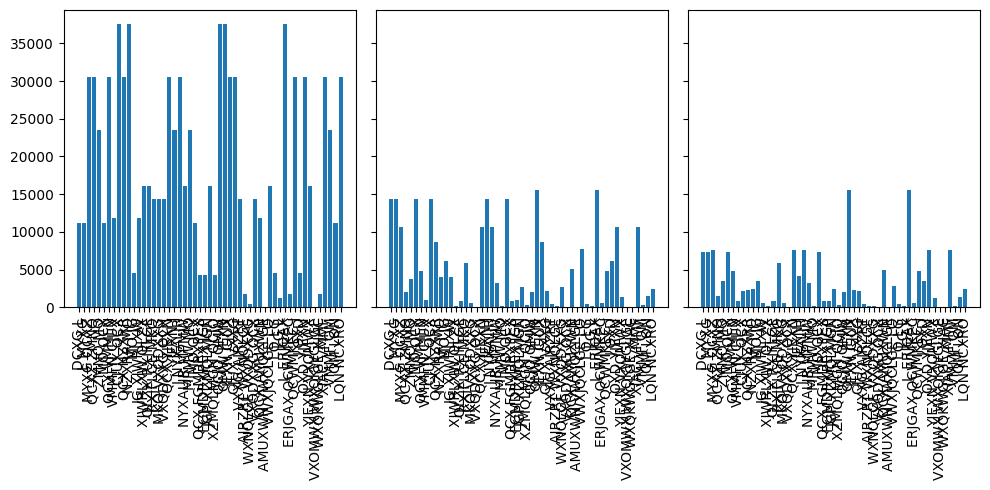

In [17]:
import matplotlib.pyplot as plt

from cryptogram import get_shared_word_length_mask, get_shared_token_sequence_mask


fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 5))

mask1 = get_shared_word_length_mask(CRYPTOGRAM, dictionary.word.tolist())
mask2 = get_shared_token_sequence_mask(X, V)
mask3 = get_shared_word_separater_mask(CRYPTOGRAM, dictionary.word.tolist())

axs[0].bar(np.arange(mask1.shape[0]), mask1.sum(axis=1))
axs[1].bar(np.arange(mask2.shape[0]), mask2.sum(axis=1))
axs[2].bar(np.arange(mask2.shape[0]), (mask1 * mask2).sum(axis=1))

for ax in axs:
    ax.set_xticks(np.arange(mask1.shape[0]), CRYPTOGRAM, rotation=90)

fig.tight_layout()

In [18]:
sum(1 for w in dictionary if len(w) == len(set(w)) and len(w) == 4)

1

# Random Scores

In [19]:
from cryptogram import word_vector_overlap

F = dictionary.log_likelihood.values
def score(π, X, V, mask):
    Xt = X.dot(π)
    matches = word_vector_overlap(Xt, V)
    ix = np.argmax(matches, axis=1)
    return F[ix].sum()

F = dictionary.log_likelihood.values
def score(π, X, V, mask):
    Xt = X.dot(π)
    matches = word_vector_overlap(np.log(Xt+1e-24), V)
    return (matches * mask).sum()

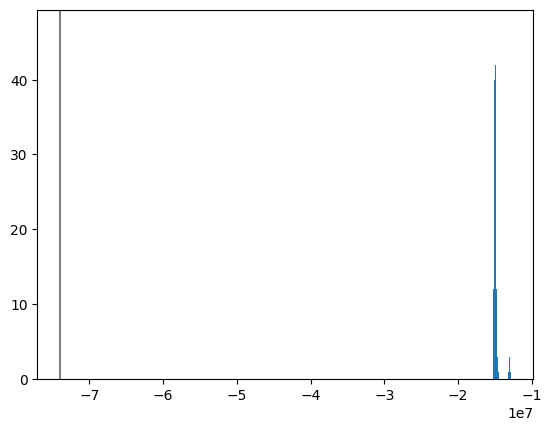

In [20]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

random_scores = []
for _ in range(250):
    π = np.eye(len(TARGET_ALPHABET))
    np.random.shuffle(π)
    random_scores.append(score(π, X, V, mask1*mask2*mask3))
ax.hist(random_scores, bins=40)

# π = np.zeros((len(CRYPTOGRAM_ALPHABET), len(TARGET_ALPHABET)))
# π[np.arange(len(CRYPTOGRAM_ALPHABET)), np.vectorize(TARGET_ALPHABET.index)(list(CRYPTOGRAM_ALPHABET))] = 1
π = np.eye(len(TARGET_ALPHABET))
true_score = score(π, X, V, mask1*mask2)
ax.axvline(true_score, color='C7')

# pytorch

In [21]:
import torch

X = torch.from_numpy(X)
V = torch.from_numpy(V)
F = torch.from_numpy(F)
mask = torch.from_numpy(mask1*mask2*mask3).type(torch.float64)

$$
P(w^{\prime}) = \sum_{w}^{}{P(w^{\prime}\vert w)P(w)}
$$

In [22]:
def word_vector_overlap(X, V):
    return torch.tensordot(X, V, dims=[[1, 2], [1, 2]])

def score(π, X, V, mask):
    Xt = X @ π
    matches = word_vector_overlap(torch.log(Xt+1e-24), V)
    return (matches*mask + F[None, :]*mask)

# def score(π, X, V, mask):
#     Xt = X @ π
#     matches = word_vector_overlap(Xt, V)
#     return (matches * mask).max(axis=1).values.sum()

def find_matches(X, V):
    return torch.tensordot(X, V, dims=[[1, 2], [1, 2]])

def make_π(σ):
    π = torch.exp(σ)
    for _ in range(3):
        for axis in [0, 1]:
            π = π / π.sum(axis=axis, keepdims=True)
    return π

σ = torch.randn(len(TARGET_ALPHABET), len(TARGET_ALPHABET), dtype=torch.float64, requires_grad=True)
π = make_π(σ)
π.sum(axis=0), π.sum(axis=1), π.shape

(tensor([1.0003, 1.0004, 1.0002, 1.0002, 1.0002, 1.0003, 0.9998, 0.9980, 0.9999,
         1.0000, 1.0001, 1.0007, 0.9990, 0.9997, 1.0004, 0.9994, 0.9998, 1.0001,
         1.0004, 0.9995, 1.0000, 1.0005, 1.0000, 1.0006, 1.0001, 0.9999, 1.0005],
        dtype=torch.float64, grad_fn=<SumBackward1>),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        dtype=torch.float64, grad_fn=<SumBackward1>),
 torch.Size([27, 27]))

In [23]:
score(π, X, V, mask).sum()

tensor(-1216067.1467, dtype=torch.float64, grad_fn=<SumBackward0>)

In [24]:
optimizer = torch.optim.Adam([σ])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [25]:
from tqdm.notebook import tqdm

def constraint(π):
    return sum(
        (1 - π.sum(axis=axis)).abs().sum()
        for axis in [0, 1]
    )

last_loss = np.inf
with tqdm(range(200000)) as pbar:
    for _ in pbar:
        π = make_π(σ)
        # loss = -score(π, X, V, mask).mean()
        # add weight for length of match
        loss = (
            -(score(π, X, V, mask) * X.sum(axis=(1, 2))[:, None]).mean()
            + torch.abs(1-π.sum(axis=0)).sum()
            + torch.abs(1-π.sum(axis=1)).sum()
        )
        loss.retain_grad()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss = loss.item()
        pbar.set_postfix(loss=f'{loss:>7f}')
        if abs(last_loss - loss) < 1e-7:
            break
        last_loss = loss

  0%|          | 0/200000 [00:00<?, ?it/s]

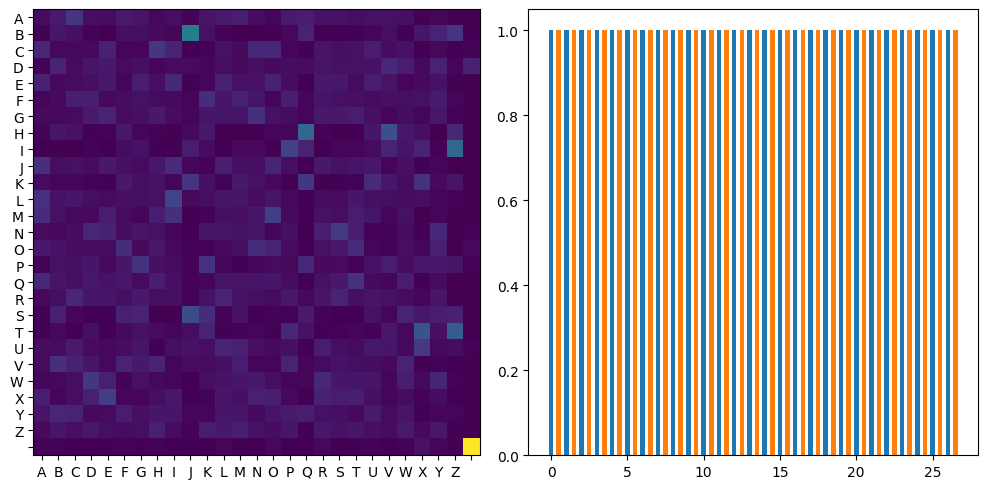

In [26]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

π = make_π(σ)
π_max = π.detach().numpy()
axs[0].imshow(π_max)
_ = axs[0].set_xticks(np.arange(len(TARGET_ALPHABET)), TARGET_ALPHABET)
_ = axs[0].set_yticks(np.arange(len(TARGET_ALPHABET)), TARGET_ALPHABET)

axs[1].bar(np.arange(π_max.shape[0]), π_max.sum(axis=1), width=.3)
axs[1].bar(np.arange(π_max.shape[1])+.5, π_max.sum(axis=0), width=.3)

fig.tight_layout()

# Solve for the cipher

In [27]:
# masked values become 0, which overtake the actual values we're looking for in `argmax`
scores = np.ma.masked_equal(score(π_max, X, V, mask).numpy(), 0.0, copy=False)

for w, ix in zip(CRYPTOGRAM, np.argmin(-scores, axis=1)):
    print(w, '->', dictionary.word.iloc[ix])

DCXG L -> WHEN A
L MYXG -> I OPEN
MYXG QCXZ -> OVER THEM
QCXZ ZMNQ -> THOU HAST
ZMNQ MO -> MOST OF
MO QCX -> IN THE
QCX VMMFN -> THE COOKS
VMMFN CJUX -> FOODS HAVE
CJUX QCX -> HAVE THE
QCX NZXRR -> THE DRESS
NZXRR MO -> SMELL OF
MO JG -> TO AN
JG XJWRLXW -> AS EARLIER
XJWRLXW QLZX -> EARLIER DATE
QLZX RXJFLGE -> TIME LEADING
RXJFLGE MKQ -> LEAKING OUT
MKQ VXQDXXG -> OUT BETWEEN
VXQDXXG QCX -> BETWEEN THE
QCX YJEXN -> THE LIVES
YJEXN J -> HEARD A
J NYXALJR -> A SPECIAL
NYXALJR MPMW -> SPECIAL THAN
MPMW MO -> ODOR OF
MO QCX -> IN THE
QCX FGMDRXPEX -> HER KNOWLEDGE
FGMDRXPEX JGP -> KNOWLEDGE HOW
JGP XZMQLMGN -> AND EMOTIONS
XZMQLMGN QCJQ -> STRIKING THAT
QCJQ OMW -> THAT FOR
OMW JEXN -> FOR MANY
JEXN CJUX -> AGES HAVE
CJUX VXXG -> HAVE BEEN
VXXG AJRZRT -> BEEN CAUSED
AJRZRT WXNQLGE -> CEASED WORKING
WXNQLGE VXQDXXG -> RESTING BETWEEN
VXQDXXG QCX -> BETWEEN THE
QCX AMUXWN -> THE COLORS
AMUXWN VWXJQCLGE -> AC HAMILTON
VWXJQCLGE LQ -> BREATHING IN
LQ LG -> IT IS
LG L -> AS A
L ERJGAX -> A DI

In [28]:
# masked values become 0, which overtake the actual values we're looking for in `argmax`
scores = np.ma.masked_equal(score(π_max, X, V, mask).numpy(), 0.0, copy=False)

translations = []
for w, ix in zip(CRYPTOGRAM, np.argmin(-scores, axis=1)):
    for w1, t1 in zip(w.split(), dictionary.word.iloc[ix].split()):
        translations.append((w1, t1))
translations = pd.DataFrame(translations, columns=['encrypted', 'decrypted'])
translations.groupby(['encrypted', 'decrypted']).size().sort_values()

encrypted  decrypted
AJRZRT     CAUSED       1
NZXRR      SMELL        1
ZMNQ       HAST         1
OXD        FEW          1
           NEW          1
                       ..
L          A            3
VXQDXXG    BETWEEN      4
J          A            4
CJUX       HAVE         4
QCX        THE          9
Length: 72, dtype: int64

In [29]:
# masked values become 0, which overtake the actual values we're looking for in `argmax`
scores = np.ma.masked_equal(score(π_max, X, V, mask).numpy(), 0.0, copy=False)

translations = []
for w, ix in zip(CRYPTOGRAM, np.argmin(-scores, axis=1)):
    for w1, t1 in zip(w.split(), dictionary.word.iloc[ix].split()):
        for c1, c2 in zip(w1, t1):
            translations.append((c1, c2))
translations = pd.DataFrame(translations, columns=['encrypted', 'decrypted'])
translation_frequencies = translations.groupby(['encrypted', 'decrypted']).size().sort_values()
translation_frequencies

encrypted  decrypted
A          A             1
N          R             1
           Y             1
O          O             1
P          W             1
                        ..
G          N            25
C          H            26
M          O            30
Q          T            35
X          E            68
Length: 89, dtype: int64

In [30]:
from scipy.optimize import linear_sum_assignment

C = translation_frequencies.unstack('decrypted').fillna(0)
C = C.reindex(list(TARGET_ALPHABET)).reindex(list(TARGET_ALPHABET), axis=1).fillna(0)
learned_cipher = {
    TARGET_ALPHABET[i]: TARGET_ALPHABET[j]
    for i, j in zip(*linear_sum_assignment(C, maximize=True))
}
learned_cipher

{'A': 'C',
 'B': 'X',
 'C': 'H',
 'D': 'W',
 'E': 'G',
 'F': 'K',
 'G': 'N',
 'H': 'Q',
 'I': 'J',
 'J': 'A',
 'K': 'U',
 'L': 'I',
 'M': 'O',
 'N': 'S',
 'O': 'F',
 'P': 'D',
 'Q': 'T',
 'R': 'L',
 'S': 'Z',
 'T': 'Y',
 'U': 'V',
 'V': 'B',
 'W': 'R',
 'X': 'E',
 'Y': 'P',
 'Z': 'M',
 ' ': ' '}

In [31]:
CRYPTOGRAM

['DCXG L',
 'L MYXG',
 'MYXG QCXZ',
 'QCXZ ZMNQ',
 'ZMNQ MO',
 'MO QCX',
 'QCX VMMFN',
 'VMMFN CJUX',
 'CJUX QCX',
 'QCX NZXRR',
 'NZXRR MO',
 'MO JG',
 'JG XJWRLXW',
 'XJWRLXW QLZX',
 'QLZX RXJFLGE',
 'RXJFLGE MKQ',
 'MKQ VXQDXXG',
 'VXQDXXG QCX',
 'QCX YJEXN',
 'YJEXN J',
 'J NYXALJR',
 'NYXALJR MPMW',
 'MPMW MO',
 'MO QCX',
 'QCX FGMDRXPEX',
 'FGMDRXPEX JGP',
 'JGP XZMQLMGN',
 'XZMQLMGN QCJQ',
 'QCJQ OMW',
 'OMW JEXN',
 'JEXN CJUX',
 'CJUX VXXG',
 'VXXG AJRZRT',
 'AJRZRT WXNQLGE',
 'WXNQLGE VXQDXXG',
 'VXQDXXG QCX',
 'QCX AMUXWN',
 'AMUXWN VWXJQCLGE',
 'VWXJQCLGE LQ',
 'LQ LG',
 'LG L',
 'L ERJGAX',
 'ERJGAX QCWMKEC',
 'QCWMKEC J',
 'J OXD',
 'OXD YJEXN',
 'YJEXN VXOMWX',
 'VXOMWX WXQKWGLGE',
 'WXQKWGLGE XJAC',
 'XJAC VMMF',
 'VMMF QM',
 'QM LQN',
 'LQN NCXRO']

In [32]:
' '.join(w.split()[0] for w in CRYPTOGRAM).translate(str.maketrans(learned_cipher))

'WHEN I OPEN THEM MOST OF THE BOOKS HAVE THE SMELL OF AN EARLIER TIME LEAKING OUT BETWEEN THE PAGES A SPECIAL ODOR OF THE KNOWLEDGE AND EMOTIONS THAT FOR AGES HAVE BEEN CALMLY RESTING BETWEEN THE COVERS BREATHING IT IN I GLANCE THROUGH A FEW PAGES BEFORE RETURNING EACH BOOK TO ITS'